In [1]:
%cd
%tensorflow_version 1.x

import os
import zipfile 
import tensorflow as tf

print(tf.__version__)

!pip install q keras==2.1.0
!git clone --quiet https://github.com/WimFlorijn/instance-segmentation-maskrcnn.git

%cd ~/instance-segmentation-maskrcnn

/root
TensorFlow 1.x selected.
1.15.2
     |████████████████████████████████| 307kB 12.5MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.0 which is incompatible.
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
/root/instance-segmentation-maskrcnn


In [2]:
!pip install -q PyDrive

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
dataset_dir = '/tmp/traindata'

zip_ref = zipfile.ZipFile('/content/gdrive/My Drive/train_data.zip', 'r')
zip_ref.extractall(dataset_dir)
zip_ref.close()

In [4]:
import os
import re
import sys
import cv2
import math
import time
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath('../../')

# Import Mask RCNN
sys.path.append(ROOT_DIR)
import mrcnn.model as modellib

from mrcnn import utils
from mrcnn import visualize
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = '/tmp/snapshot'

Using TensorFlow backend.


In [0]:
def get_ax(rows=1, cols=1, size=8):
    """ Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """

    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))

    return ax

In [0]:
class SketchDataset(utils.Dataset):

    def load_sketch(self, image_ids):
        self.add_class("sketch", 1, "measurement")
        self.add_class("sketch", 2, "parcel_number")

        for image_id in image_ids:
          path = os.path.join(dataset_dir, image_id, 'image.tif')
          self.add_image("sketch", image_id=image_id, path=path)

    def load_mask(self, image_id):
        # Get mask directory from image path
        dataset_dir = '/tmp/traindata'
        
        info = self.image_info[image_id]
        
        # Get mask directory from image path
        mask_dirs = ['measurement_masks', 'parcel_number_masks']

        # Read mask files from .png image
        masks, labels = [], []
        mask_shape = (config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM)
        for i, name in enumerate(mask_dirs):
            path_dir = os.path.dirname(info['path'])
            mask_dir = os.path.join(dataset_dir, path_dir, name)
            if os.path.exists(mask_dir) and len(os.listdir(mask_dir)) != 0:
                for f in next(os.walk(mask_dir))[2]:
                    mask_img=np.zeros(mask_shape, dtype=np.bool)
                    m = np.load(os.path.join(mask_dir, f))
                    mask_img[m[0], m[1]] = 1
                    masks.append(mask_img)
                    labels.append(i + 1)
        
        if len(masks):
            masks = np.stack(masks, axis=-1)
            labels = np.asarray(labels, dtype=np.int32)
        else:
            masks = np.zeros((config.IMAGE_MAX_DIM, config.IMAGE_MIN_DIM, 0),
                             dtype=np.bool)
            labels = np.array([])

        return masks, labels

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "sketch":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [7]:
image_ids = next(os.walk(dataset_dir))[1]

# Add images
random.shuffle(image_ids)

split = .95
image_ids_length = len(image_ids)
split_idx = int(image_ids_length * split)
train_ids, val_ids = image_ids[:split_idx], image_ids[split_idx:]

train_size, test_size = len(train_ids), len(val_ids)
print('Train set size: {train_size}.'.format(train_size=train_size))
print('Validation set size: {test_size}.'.format(test_size=test_size))

# Training dataset
dataset_train = SketchDataset()
dataset_train.load_sketch(train_ids)
dataset_train.prepare()

# Validation dataset
dataset_val = SketchDataset()
dataset_val.load_sketch(val_ids)
dataset_val.prepare()

Train set size: 2709.
Validation set size: 143.


In [8]:
class SketchConfig(Config):

    # Give the configuration a recognizable name
    NAME = "sketch"

    BACKBONE='resnet50'

    USE_MINI_MASK = True

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + measurement + parcel number

    # Use small images for faster training. Set the limits of the small side
    # the large side, which determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 1280

    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.7

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3
    
    # Percent of positive ROIs used to train classifier/mask heads
    ROI_POSITIVE_RATIO = 0.33

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 24, 32, 40)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 300

    # Epoch size should approximate train set
    STEPS_PER_EPOCH = train_size

    # Epoch size should approximate validation set
    VALIDATION_STEPS = test_size

config = SketchConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1280
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1280 1280    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

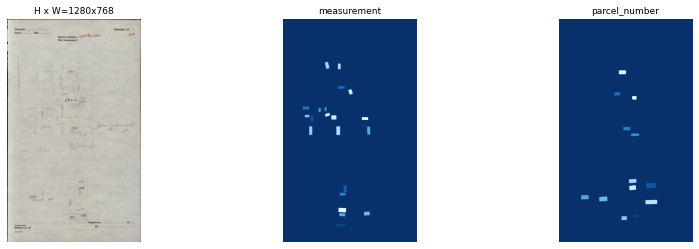

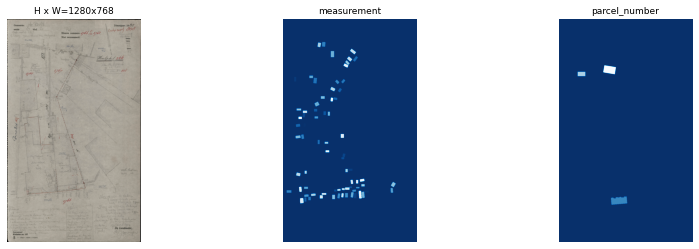

In [9]:
# Load and display random samples
for image_id in np.random.choice(dataset_train.image_ids, 2):
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names,
                                limit=config.NUM_CLASSES - 1)

In [0]:
# Create model in training mode

model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [0]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Local path to trained weights file
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    # Download COCO trained weights from Releases if needed
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    model_path = '/content/gdrive/My Drive/rcnn_snapshot/weights_initial.h5'
    print("Loading weights from ", model_path)
    model.load_weights(model_path)


... done downloading pretrained model!








In [0]:
import keras

# Train the head branches

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_initial.h5',
    monitor='val_loss', save_best_only=False, save_weights_only=True)

model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=300,
            layers='heads',
            custom_callbacks=[early_stopping, model_checkpoint])


Starting at epoch 0. LR=0.001

Checkpoint Path: /tmp/snapshot/sketch20200421T0709/mask_rcnn_sketch_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/300
2708/2709 [============================>.] - ETA: 4s - loss: 1.5488 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.3334

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'



2709/2709 [==============================] - 11983s 4s/step - loss: 1.5488 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 0.5683 - mrcnn_class_loss: 0.2858 - mrcnn_bbox_loss: 0.2971 - mrcnn_mask_loss: 0.3334 - val_loss: 1.3836 - val_rpn_class_loss: 0.0396 - val_rpn_bbox_loss: 0.4791 - val_mrcnn_class_loss: 0.3044 - val_mrcnn_bbox_loss: 0.2602 - val_mrcnn_mask_loss: 0.3002
Epoch 2/300
2709/2709 [==============================] - 11071s 4s/step - loss: 1.2814 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.4326 - mrcnn_class_loss: 0.2855 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.2885 - val_loss: 1.2485 - val_rpn_class_loss: 0.0290 - val_rpn_bbox_loss: 0.4153 - val_mrcnn_class_loss: 0.2987 - val_mrcnn_bbox_loss: 0.2278 - val_mrcnn_mask_loss: 0.2778
Epoch 3/300
2709/2709 [==============================] - 11307s 4s/step - loss: 1.1892 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.2752 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.2751 - val_loss: 1.1516 - val_rpn_cla

In [0]:
# Finetuning step 1

model_checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_fine_1.h5',
    monitor='val_loss', save_best_only=True)

model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE,
            epochs=300,
            layers='all',
            custom_callbacks=[early_stopping, model_checkpoint])

In [0]:
# Finetuning step 2

model_checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/gdrive/My Drive/rcnn_snapshot/weights_fine_2.h5',
    monitor='val_loss', save_best_only=True)

model.train(dataset_train,
            dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=300,
            layers='all',
            custom_callbacks=[early_stopping, model_checkpoint])

In [11]:
class InferenceConfig(SketchConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights
model_path = '/content/gdrive/My Drive/rcnn_snapshot/weights_initial.h5'
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/gdrive/My Drive/rcnn_snapshot/weights_initial.h5








original_image           shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1280.00000  int64
gt_class_id              shape: (92,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (92, 4)               min:  211.00000  max: 1059.00000  int32
gt_mask                  shape: (1280, 1280, 92)      min:    0.00000  max:    1.00000  bool


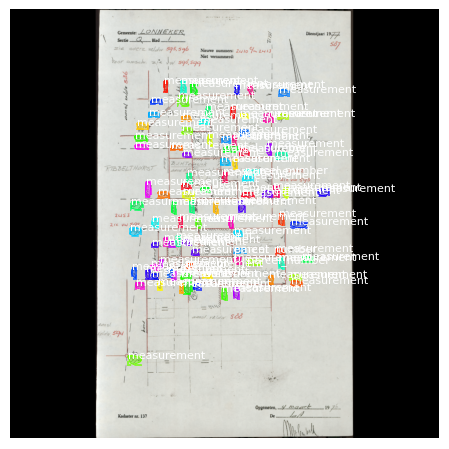

Processing 1 images
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1280, 1280, 3)    min: -123.70000  max:  147.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1280.00000  int64
anchors                  shape: (1, 409200, 4)        min:   -0.02211  max:    1.00259  float32


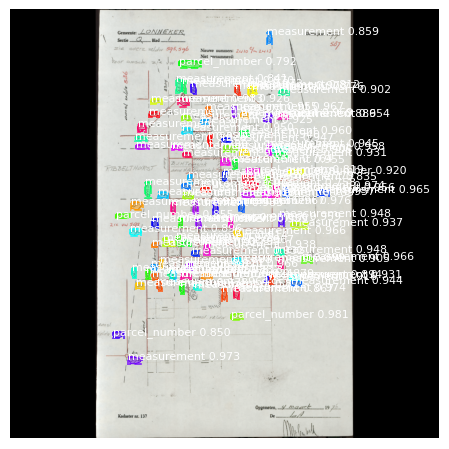

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(dataset_val, inference_config, image_id,
                           use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
masked_image = visualize.display_instances(
    original_image, r['rois'], r['masks'], r['class_ids'],
    dataset_val.class_names, r['scores'], ax=get_ax())